In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.somsc import somsc
from pyclustering.cluster.xmeans import xmeans, splitting_type
from pyclustering.samples.definitions import FCPS_SAMPLES, SIMPLE_SAMPLES

# Clustering

In [2]:
customer_indicators = pd.read_csv('datasets/customer_indicators.csv', index_col=0)

### Pre-processing

In [3]:
dataset = customer_indicators[['RMonetary']].apply(np.log10, axis=1).round(3)
dataset['Delta'] = customer_indicators[['Delta']].apply(np.log10, axis=1).round(3)
dataset['Recency'] = customer_indicators[['Recency']]
dataset['CustomerID'] = customer_indicators[['CustomerID']]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(dataset[['Delta', 'Recency', 'RMonetary']].values)

## K-means

In [4]:
sse = []
silhouette = []
kmax = 19
for k in range(2, kmax):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(data_scaled, kmeans.labels_))

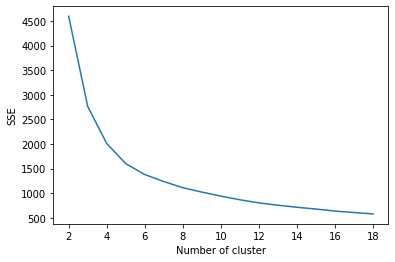

In [5]:
# Elbow curve.
ax = plt.plot(range(2, kmax), sse)
plt.xlabel('Number of cluster')
plt.ylabel('SSE')
plt.show()

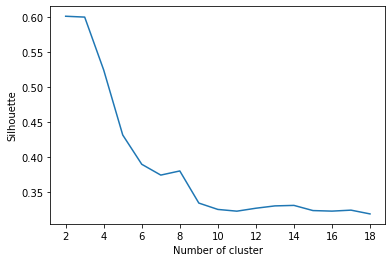

In [6]:
# Silhouette score.
ax = plt.plot(range(2, kmax), silhouette)
plt.xlabel('Number of cluster')
plt.ylabel('Silhouette')
plt.show()

SSE: 
1379.0201334934793
Silhouette: 
0.3897381894323612


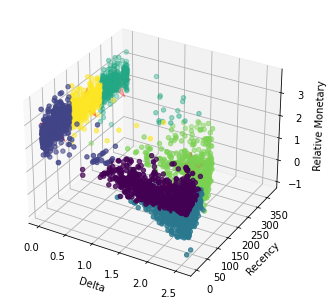

In [7]:
# kmeans best choice parameters

k_best = 6
kmeans_best = KMeans(n_clusters=k_best, n_init=10, max_iter=100)
kmeans_best.fit(data_scaled)
print('SSE: ') 
print(kmeans_best.inertia_)
print('Silhouette: ') 
print(silhouette_score(data_scaled, kmeans_best.labels_))

centers = scaler.inverse_transform(kmeans_best.cluster_centers_)
centroids_x = centers[:,0]
centroids_y = centers[:,1]
centroids_z = centers[:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dataset['Delta'], dataset['Recency'], dataset['RMonetary'], c=kmeans_best.labels_)
ax.scatter(centroids_x,centroids_y,centroids_z,s=1000, marker='*', c='r')
ax.set_xlabel('Delta')
ax.set_ylabel('Recency')
ax.set_zlabel('Relative Monetary')
plt.show()

### Post-processing

In [8]:
# create column containing cluster label
dataset['Behavior'] = kmeans_best.labels_
dataset.head()

,RMonetary,Delta,Recency,CustomerID,Behavior
0,1.071,2.563,2,12347,0
1,0.706,2.452,75,12348,2
2,3.164,0.000,19,12349,1
3,2.469,0.000,310,12350,3
4,0.725,2.417,36,12352,2


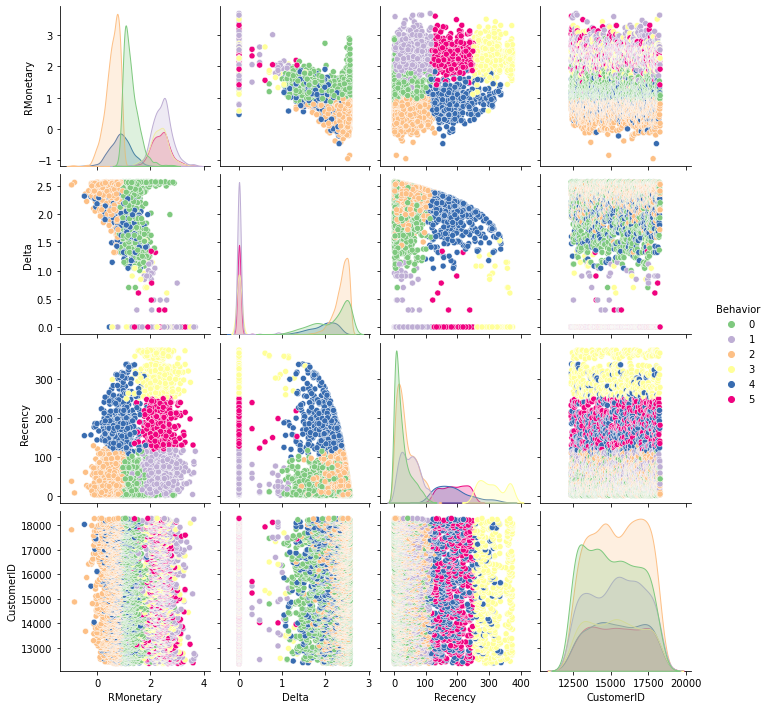

In [9]:
sns.pairplot(data=dataset, hue="Behavior", palette="Accent")
plt.show()

In [10]:
clusters = list()
for i in range(0, 6):
    clusters.append(dataset[dataset['Behavior'] == i])

In [11]:
for i in range(0, len(clusters)):
    print(clusters[i].describe())

         RMonetary        Delta      Recency    CustomerID  Behavior
count  1035.000000  1035.000000  1035.000000   1035.000000    1035.0
mean      1.269129     2.158637    24.629952  15071.044444       0.0
std       0.291237     0.408184    24.759369   1728.719704       0.0
min       0.803000     0.699000     1.000000  12347.000000       0.0
25%       1.061000     1.848000     5.000000  13528.500000       0.0
50%       1.198000     2.316000    16.000000  14963.000000       0.0
75%       1.409500     2.515000    35.000000  16581.000000       0.0
max       2.897000     2.573000   116.000000  18287.000000       0.0
        RMonetary       Delta     Recency    CustomerID  Behavior
count  770.000000  770.000000  770.000000    770.000000     770.0
mean     2.429499    0.027549   50.172727  15354.654545       1.0
std      0.365560    0.154895   29.260367   1724.688068       0.0
min      0.771000    0.000000    1.000000  12349.000000       1.0
25%      2.199250    0.000000   25.000000  13860.

## DBSCAN

In [12]:
dist = pdist(data_scaled, 'euclidean')
dist = squareform(dist)

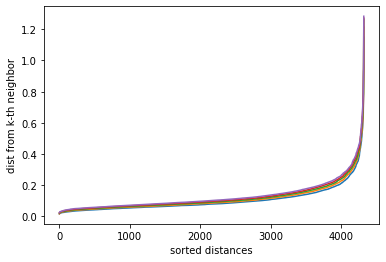

In [13]:
plt.ylabel('dist from k-th neighbor')
plt.xlabel('sorted distances')
plt.tick_params(axis='both')
for k in range(5, 10):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))

## Grid search

In [14]:
eps_to_test = [round(eps, 1) for eps in np.arange(0.1, 1, 0.1)]
min_samples_to_test = range(5, 50, 5)

In [15]:
def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting
    dbscan_model_ = DBSCAN(eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean Noise Point Distance metric
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
         
    return(noise_mean_distance, number_of_clusters)

In [16]:
# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test), len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test), len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

In [17]:
iter_ = 0

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        # Computing metrics
        noise_metric, cluster_metric = get_metrics(eps, min_samples, data_scaled, iter_)
        
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

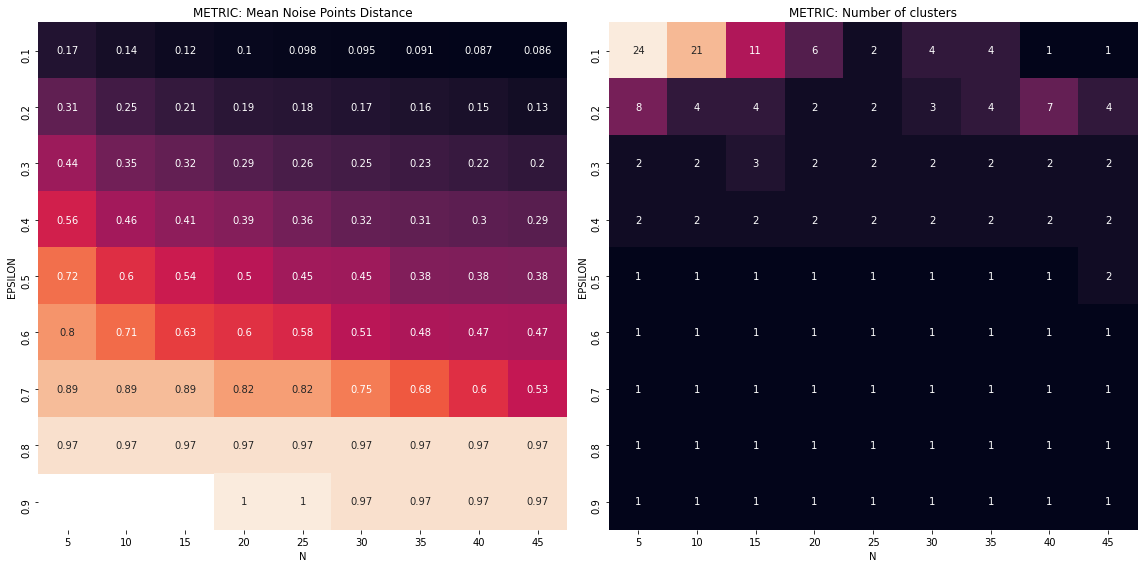

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")

ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")

plt.tight_layout(); plt.show()

In [19]:
# Best parameters
density = DBSCAN(eps=0.4, min_samples=5).fit(data_scaled)
labels = density.labels_
print(metrics.silhouette_score(data_scaled, labels))

results = np.unique(labels, return_counts=True)
print(f"Clusters labels: {results[0]}")
print(f"Elements per cluster: {results[1]}")

0.502074955044931
Clusters labels: [-1  0  1]
Elements per cluster: [  21 2745 1556]


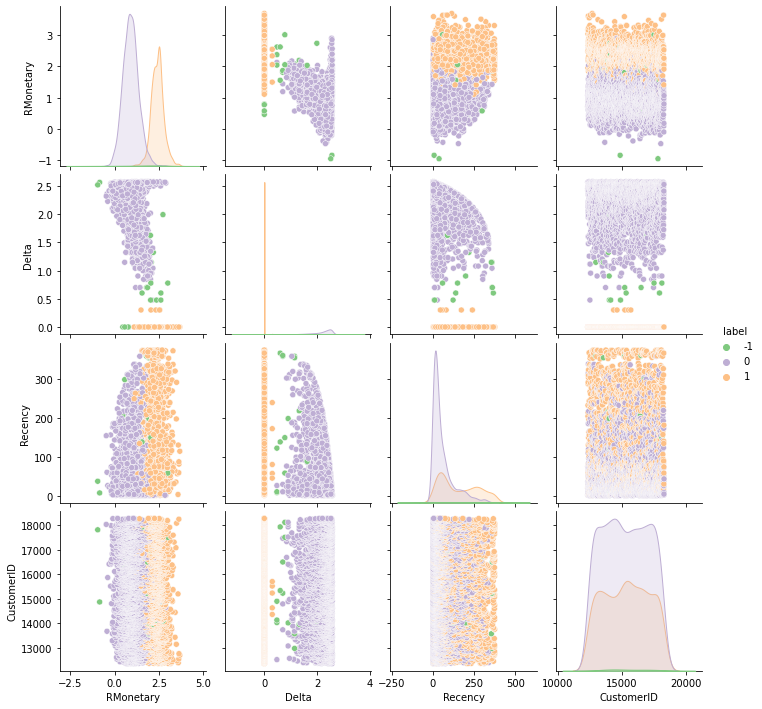

In [20]:
dbscan_df = dataset.copy()
del dbscan_df['Behavior']
dbscan_df["label"] = labels
sns.pairplot(data=dbscan_df, hue="label", palette="Accent")
plt.show()

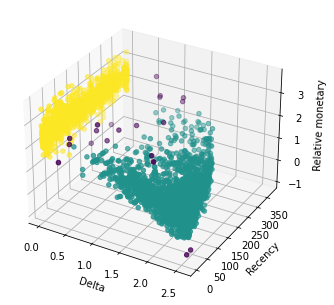

In [21]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dataset['Delta'], dataset['Recency'], dataset['RMonetary'], c=density.labels_)
ax.set_xlabel('Delta')
ax.set_ylabel('Recency')
ax.set_zlabel('Relative monetary')
plt.show()

# Hierarchical

In [22]:
dataset = customer_indicators[['RMonetary']].apply(np.log10, axis=1).round(3)
dataset['Delta'] = customer_indicators[['Delta']].apply(np.log10, axis=1).round(3)
dataset['Recency'] = customer_indicators[['Recency']]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(dataset[['Delta', 'Recency', 'RMonetary']].values)

dataframe_scaled = pd.DataFrame(data_scaled, columns=['Delta', 'Recency', 'RMonetary'])
dataframe_scaled

,Delta,Recency,RMonetary
0,1.051627,-0.905630,-0.449486
1,0.950599,-0.176149,-0.887405
2,-1.281121,-0.735751,2.061651
3,-1.281121,2.172178,1.227805
4,0.918744,-0.565872,-0.864610
...,...,...,...
4317,-1.281121,1.852406,0.973452
4318,-1.281121,0.883096,0.554729
4319,0.608378,-0.845673,-1.524488
4320,1.016131,-0.885644,-0.779425


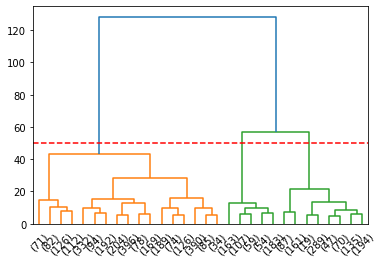

In [23]:
threshold = 50
data_dist = pdist(data_scaled, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=threshold, color='r', linestyle='--')
clusters = fcluster(data_link, threshold,  criterion='distance')

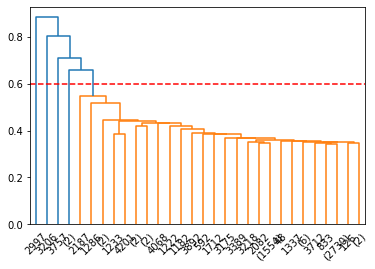

In [24]:
threshold = 0.6
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=threshold, color='r', linestyle='--')
clusters = fcluster(data_link, threshold,  criterion='distance')

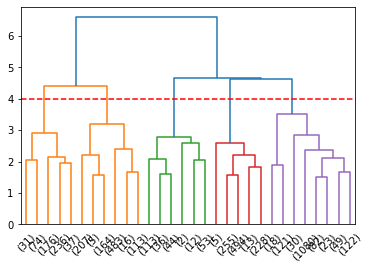

In [25]:
threshold = 4
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=threshold, color='r', linestyle='--')
clusters = fcluster(data_link, threshold,  criterion='distance')

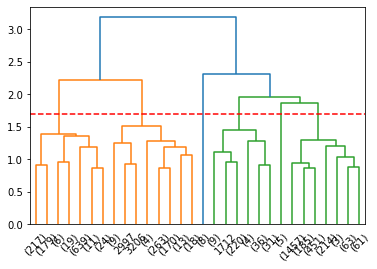

In [26]:
threshold = 1.7
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=threshold, color='r', linestyle='--')
clusters = fcluster(data_link, threshold,  criterion='distance')

Text(0, 0.5, 'Recency')

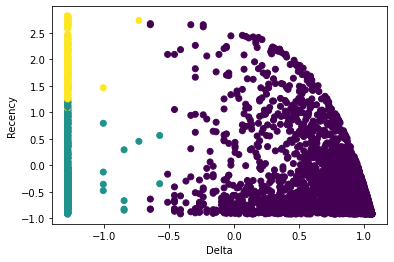

In [27]:
agg_ward = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
agg_ward.fit_predict(data_scaled)
plt.scatter(dataframe_scaled['Delta'], dataframe_scaled['Recency'], c=agg_ward.labels_)
plt.xlabel('Delta')
plt.ylabel('Recency')

Text(0, 0.5, 'Recency')

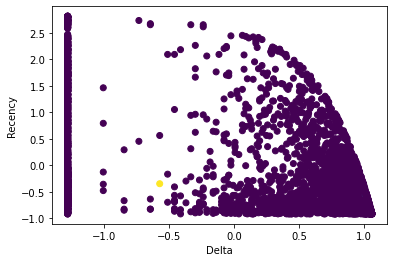

In [28]:
agg_single = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')  
agg_single.fit_predict(data_scaled)
plt.scatter(dataframe_scaled['Delta'], dataframe_scaled['Recency'], c=agg_single.labels_) 
plt.xlabel('Delta')
plt.ylabel('Recency')

Text(0, 0.5, 'Recency')

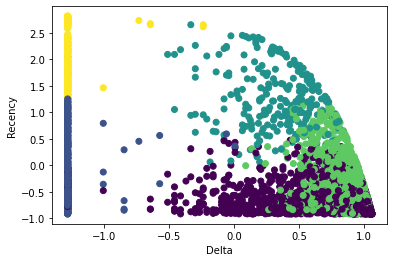

In [29]:
agg_comp = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')  
agg_comp.fit_predict(data_scaled)
plt.scatter(dataframe_scaled['Delta'], dataframe_scaled['Recency'], c=agg_comp.labels_) 
plt.xlabel('Delta')
plt.ylabel('Recency')

Text(0, 0.5, 'Recency')

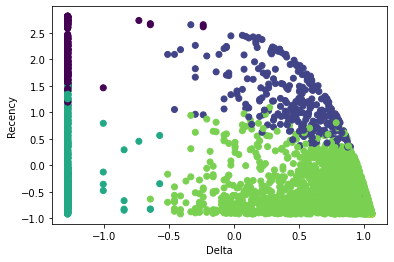

In [30]:
agg_avg = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='average')  
agg_avg.fit_predict(data_scaled)
plt.scatter(dataframe_scaled['Delta'], dataframe_scaled['Recency'], c=agg_avg.labels_) 
plt.xlabel('Delta')
plt.ylabel('Recency')

## Comparisons

In [31]:
labels_kmeans = kmeans.labels_
labels_comp = agg_comp.labels_
labels_avg = agg_avg.labels_
labels_ward = agg_ward.labels_
labels_single = agg_single.labels_

kmean_sil = metrics.silhouette_score(dataframe_scaled, labels_kmeans)
ward_sil = metrics.silhouette_score(dataframe_scaled, labels_ward) 
avg_sil = metrics.silhouette_score(dataframe_scaled,labels_avg)  
comp_sil = metrics.silhouette_score(dataframe_scaled, labels_comp)
single_sil = metrics.silhouette_score(dataframe_scaled, labels_single)

print(kmean_sil)
print(ward_sil)
print(avg_sil)
print(comp_sil)
print(single_sil)

0.31871864371520525
0.5830440476494503
0.43121753715844485
0.38150720689013706
-0.10933764663803848


# Extra: X-Means

In [32]:
# initial centers - optional parameter, if it is None, then random centers will be used by the algorithm.
# avoid random initial centers and initialize them using K-Means++ method

initial_centers = kmeans_plusplus_initializer(data_scaled, 2).initialize();
xmeans_instance = xmeans(data_scaled, initial_centers, criterion=splitting_type.BAYESIAN_INFORMATION_CRITERION, ccore=True);

### Bayesian Information Criterion

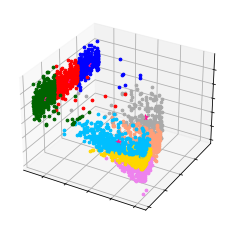

In [33]:
initial_centers = kmeans_plusplus_initializer(data_scaled, 2).initialize();
xmeans_instance = xmeans(data_scaled, initial_centers, criterion=splitting_type.BAYESIAN_INFORMATION_CRITERION, ccore=True);

# run cluster analysis
xmeans_instance.process();

# obtain results of clustering
clusters = xmeans_instance.get_clusters();
centers = xmeans_instance.get_centers()

# display allocated clusters
visualizer = cluster_visualizer();
visualizer.append_clusters(clusters, data_scaled);
visualizer.append_cluster(centers, None, marker = '*');
visualizer.show();

### Minimum Noiseless Description Length

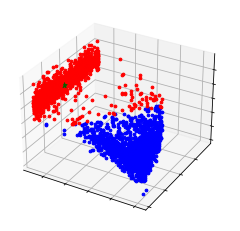

In [34]:
initial_centers = kmeans_plusplus_initializer(data_scaled, 2).initialize();
xmeans_instance = xmeans(data_scaled, initial_centers, criterion=splitting_type.MINIMUM_NOISELESS_DESCRIPTION_LENGTH, ccore=True);

# run cluster analysis
xmeans_instance.process();

# obtain results of clustering
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

# display allocated clusters
visualizer = cluster_visualizer();
visualizer.append_clusters(clusters, data_scaled);
visualizer.append_cluster(centers, None, marker = '*');
visualizer.show();

# SOM-SC

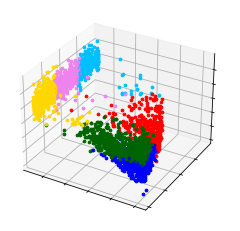

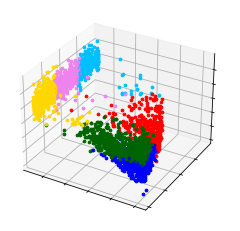

In [35]:
# Create instance of SOM-SC algorithm to allocated six clusters
somsc_instance = somsc(data_scaled, 6)

# Run cluster analysis and obtain results
somsc_instance.process()
clusters = somsc_instance.get_clusters()

# Visualize clustering results.
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, data_scaled)
visualizer.show()

# Preparation for classification

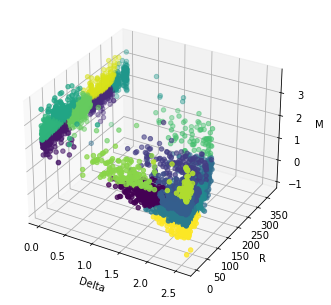

In [36]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dataset['Delta'], dataset['Recency'], dataset['RMonetary'], c=kmeans.labels_)
ax.set_xlabel('Delta')
ax.set_ylabel('R')
ax.set_zlabel('M')
plt.show()

The customers with delta = 0 (the delta axis is log-transformed) have observations for only one day, so we can't derive an effective classification among high, medium or low spending, and we remove them for the next task.

In [37]:
low = dataset[(dataset['Delta'] == 0) & (dataset['Recency'] > 60)]
dataset = dataset[dataset['Delta'] != 0]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(dataset[['Delta', 'Recency', 'RMonetary']].values)

In [38]:
sse = []
silhouette = []
kmax = 6
for k in range(2, kmax):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(data_scaled, kmeans.labels_))
dataset['Behavior'] = kmeans.labels_

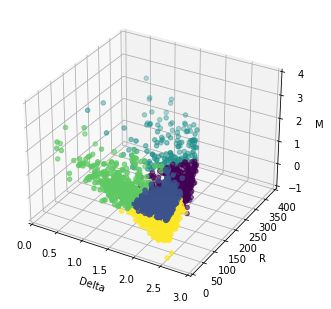

In [39]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dataset['Delta'], dataset['Recency'], dataset['RMonetary'], c=kmeans.labels_)
ax.set_xlabel('Delta')
ax.set_ylabel('R')
ax.set_zlabel('M')

ax.set_xlim3d(0, 3)
ax.set_ylim3d(0, 400)
ax.set_zlim3d(-1, 4)

plt.show()

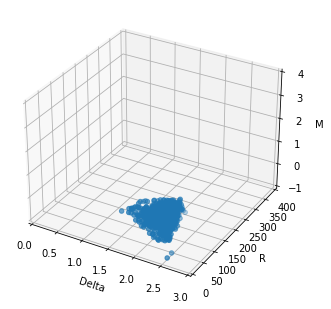

In [40]:
x = dataset[dataset['Behavior'] == 4]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x['Delta'], x['Recency'], x['RMonetary'])
ax.set_xlabel('Delta')
ax.set_ylabel('R')
ax.set_zlabel('M')

ax.set_xlim3d(0, 3)
ax.set_ylim3d(0, 400)
ax.set_zlim3d(-1, 4)

plt.show()

In [41]:
def Score(x):
    if x == 1:
        return 'High'
    elif x == 3:
        return 'Low'
    else:
        return 'Medium'

In [42]:
dataset['Label'] = dataset['Behavior'].apply(Score)
del dataset['Behavior']
dataset.head()

,RMonetary,Delta,Recency,Label
0,1.071,2.563,2,High
1,0.706,2.452,75,Medium
4,0.725,2.417,36,Medium
8,0.914,2.481,23,High
10,0.791,2.176,2,Medium


In [43]:
low['Label'] = 'Low'

In [44]:
result = dataset.append(low)

In [45]:
#result.to_csv('datasets/clustering_labels.csv')